In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt


In [85]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_values_by_bin(data, key, num_bins):
    bin_values = [[] for _ in range(num_bins)]
    for phen_data in data.values():
        for bin_data in phen_data[key]:
            bin_index = bin_data['index' if key == 'sigma' else 'bin']
            if bin_index < num_bins:
                bin_values[bin_index].append(bin_data[key])
    return bin_values

def process_py_rhe_data(folder_path, num_files, num_bins):
    py_rhe_sigma = [[] for _ in range(num_bins)]
    py_rhe_h2 = [[] for _ in range(num_bins)]
    py_rhe_enrichment = [[] for _ in range(num_bins)]

    for i in range(num_files):
        file_path = os.path.join(folder_path, f'output_{i}.json')
        file_data = read_json_file(file_path)
        for bin_index in range(num_bins):
            py_rhe_sigma[bin_index].append(file_data['sigma_ests_total'][bin_index])
            py_rhe_h2[bin_index].append(file_data['h2_total'][bin_index])
            py_rhe_enrichment[bin_index].append(file_data['enrichment_total'][bin_index])

    return py_rhe_sigma, py_rhe_h2, py_rhe_enrichment

def summarize_results(use_cov, num_bins, num_samples):
    if use_cov:
        cov = "cov"
    else:
        cov = "no_cov"
    ori_file_path = f'/u/home/j/jiayini/project-sriram/RHE_project/results/original_result/ori_result_{cov}_{num_bins}.json'
    pyrhe_folder = f'/u/home/j/jiayini/project-sriram/RHE_project/results/pyrhe_output/{cov}/bin_{num_bins}'

    ori_data = read_json_file(ori_file_path)
    pyrhe_sigma, pyrhe_h2, pyrhe_enrichment = process_py_rhe_data(pyrhe_folder, num_samples, num_bins)

    ori_sigma_bins = extract_values_by_bin(ori_data, 'sigma', num_bins)
    ori_h2_bins = extract_values_by_bin(ori_data, 'h2', num_bins)
    ori_enrichment_bins = extract_values_by_bin(ori_data, 'enrichment', num_bins)

    colors = plt.cm.get_cmap('tab10', num_bins)

    plt.figure(figsize=(18, 6))

    for bin_index in range(num_bins):
        color = colors(bin_index)

        plt.subplot(1, 3, 1)
        plt.boxplot([ori_sigma_bins[bin_index], pyrhe_sigma[bin_index]], positions=[bin_index*2, bin_index*2+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color))
        
        plt.subplot(1, 3, 2)
        plt.boxplot([ori_h2_bins[bin_index], pyrhe_h2[bin_index]], positions=[bin_index*2, bin_index*2+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color))

        plt.subplot(1, 3, 3)
        plt.boxplot([ori_enrichment_bins[bin_index], pyrhe_enrichment[bin_index]], positions=[bin_index*2, bin_index*2+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color))

    plt.subplot(1, 3, 1)
    plt.title('Sigma Estimates by Bin')
    plt.xlabel('Bin')
    plt.ylabel('Sigma Value')
    plt.xticks(ticks=np.arange(0, 2*num_bins, 2) + 0.5, labels=[str(i+1) for i in range(num_bins)])

    plt.subplot(1, 3, 2)
    plt.title('h2 Estimates by Bin')
    plt.xlabel('Bin')
    plt.ylabel('h2 Value')
    plt.xticks(ticks=np.arange(0, 2*num_bins, 2) + 0.5, labels=[str(i+1) for i in range(num_bins)])

    plt.subplot(1, 3, 3)
    plt.title('Enrichment Estimates by Bin')
    plt.xlabel('Bin')
    plt.ylabel('Enrichment Value')
    plt.xticks(ticks=np.arange(0, 2*num_bins, 2) + 0.5, labels=[str(i+1) for i in range(num_bins)])

    plt.suptitle(f'Comparison of Original and PyRHE Results for Each Bin')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2765/998461508.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_bins)


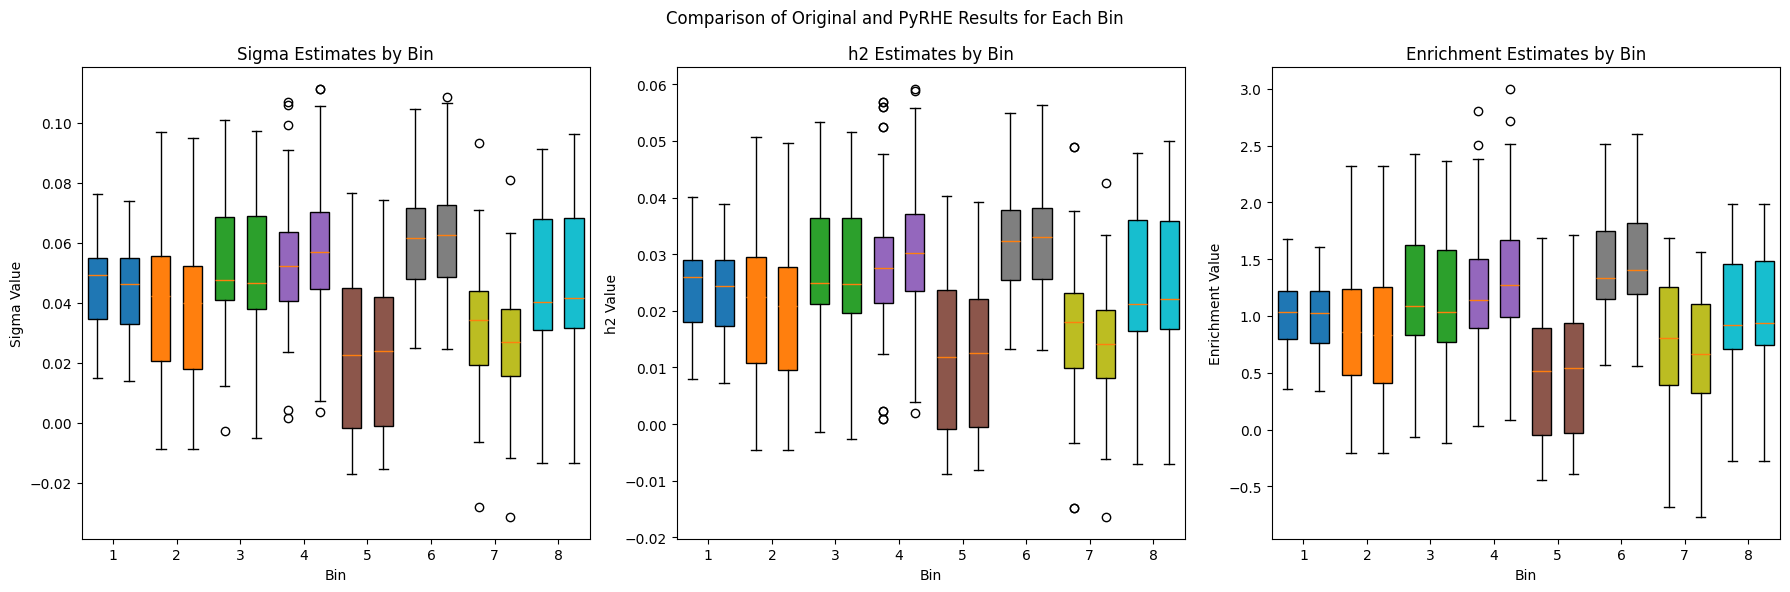

In [86]:
summarize_results(True, 8, 25)


/tmp/ipykernel_2765/998461508.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_bins)


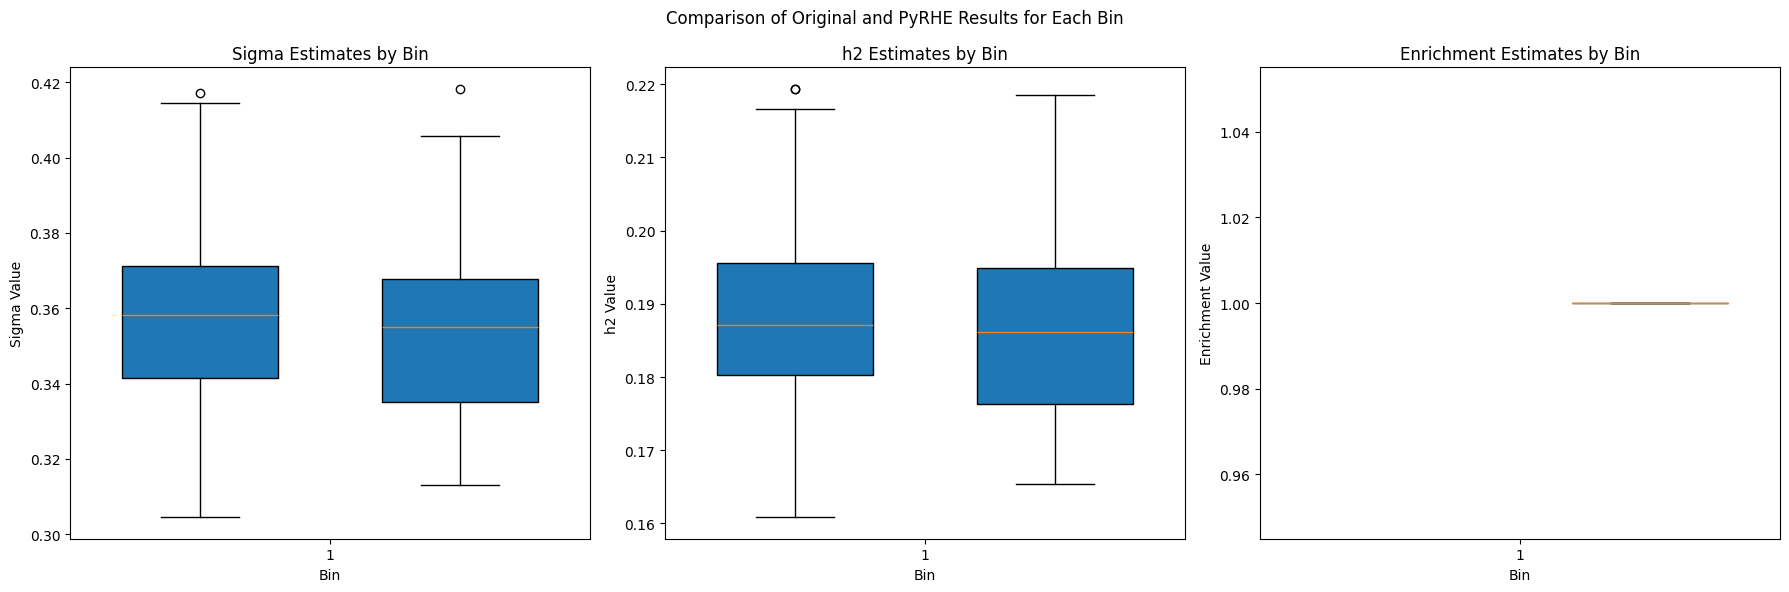

In [87]:
summarize_results(True, 1, 25)
